In [4]:
import numpy as np
import bayespy as bp
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib import cm
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
import scipy.stats
import os
import json
from tqdm import tqdm_notebook
import multiprocessing
import functools as ft
import time_series
import importlib
importlib.reload(time_series)
from time_series import *

%matplotlib inline
style.use('../figures/scrartcl.mplstyle')

In [5]:
hyperparameters = os.environ.get('HYPERPARAMETERS')
if hyperparameters:
    with open(hyperparameters) as fp:
        hyperparameters = json.load(fp)
else:
    hyperparameters = {
        'rho/concentration': 1e-3,
        'Lambda/shape': 0.0,     # We will add on the dimensionality of the space
        # 'Lambda/scale': [2e-3, 1e-2, 2e-2, 4e-2, 0.2, 2, 20],  # We will multiply by the identity matrix and the dimension
        'Lambda/scale': list(np.logspace(-2.5, .5, 19)),
        'tau/shape': 1e-3,
        'tau/scale': 1e-3,
        'lambda/shape': 1e-5,
        'lambda/scale': 1e-5,
        'ard_prior': 'independent',
        'num_groups': 10,
        'num_factors': [1, 2, 3, 4],
        'seed': [2, 3, 4, 5],
        'tolerance': 1e-6,
        'initialization': 'kmeans',
    }
    
print(json.dumps(hyperparameters, indent=4))

{
    "rho/concentration": 0.001,
    "Lambda/shape": 0.0,
    "Lambda/scale": [
        0.0031622776601683794,
        0.004641588833612777,
        0.006812920690579615,
        0.01,
        0.01467799267622069,
        0.021544346900318832,
        0.03162277660168379,
        0.046415888336127774,
        0.06812920690579612,
        0.1,
        0.1467799267622069,
        0.21544346900318834,
        0.31622776601683794,
        0.46415888336127775,
        0.6812920690579608,
        1.0,
        1.467799267622069,
        2.154434690031882,
        3.1622776601683795
    ],
    "tau/shape": 0.001,
    "tau/scale": 0.001,
    "lambda/shape": 1e-05,
    "lambda/scale": 1e-05,
    "ard_prior": "independent",
    "num_groups": 10,
    "num_factors": [
        1,
        2,
        3,
        4
    ],
    "seed": [
        2,
        3,
        4,
        5
    ],
    "tolerance": 1e-06,
    "initialization": "kmeans"
}


In [6]:
num_factors = 2
num_nodes = 50
num_obs = 100
num_groups = 5
concentration = 1e3
# p_missing = 0.05
p_missing = 0

0.0

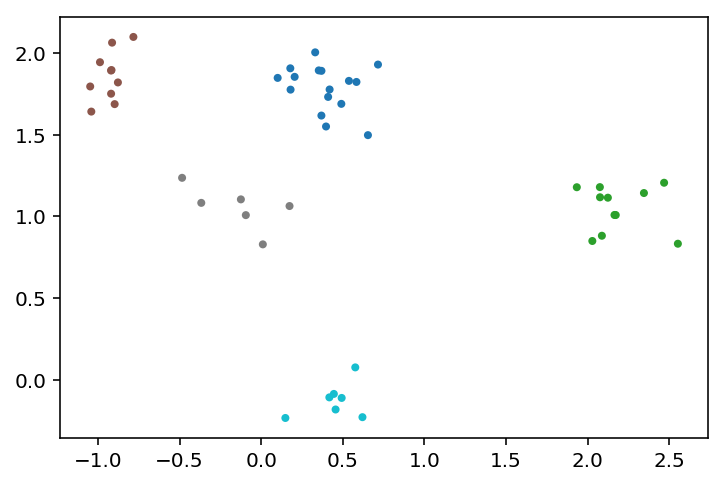

In [7]:
np.random.seed(0)
mu = np.random.normal(0, 1, (num_groups, num_factors))
Lambda = scipy.stats.wishart.rvs(50, np.eye(num_factors), num_groups)
rho = np.random.dirichlet(concentration * np.ones(num_groups))
idx = np.random.choice(num_groups, num_nodes, p=rho)
z = np.ones((num_nodes, num_groups))
z[np.arange(num_nodes), idx] = 1
A = mu[idx] + np.einsum('ijk,ik->ij', np.linalg.cholesky(np.linalg.inv(Lambda))[idx], 
                        np.random.normal(0, 1, (num_nodes, num_factors)))
A = A[:, ::-1]
x = np.random.normal(0, 1, (num_obs, num_factors))
predictor = np.dot(x, A.T)
tau = np.random.gamma(100, 1 / 10, num_nodes)
y = predictor + np.random.normal(0, 1 / np.sqrt(tau), (num_obs, num_nodes))
y[np.random.uniform(size=y.shape) < p_missing] = np.nan

fig, ax = plt.subplots()
ax.scatter(*A.T, c=idx, cmap='tab10', marker='.')
ax.set_aspect(1)

np.mean(np.isnan(y))

# Model without community structure

In [8]:
variables, list_params = build_parameters(hyperparameters, 'num_factors', 'seed', seed=list(range(20)),
                                          num_factors=[1, 2, 3, 4, 5, 6, 7, 8, 9])

def target(hyperparameters):
    np.random.seed(hyperparameters['seed'])
    Q = latent_factor_model(y, hyperparameters)
    Q.update(repeat=None, verbose=False, tol=hyperparameters['tolerance'])
    return Q

with multiprocessing.Pool() as pool:
    models = list(tqdm_notebook(pool.imap(target, list_params), total=len(list_params)))

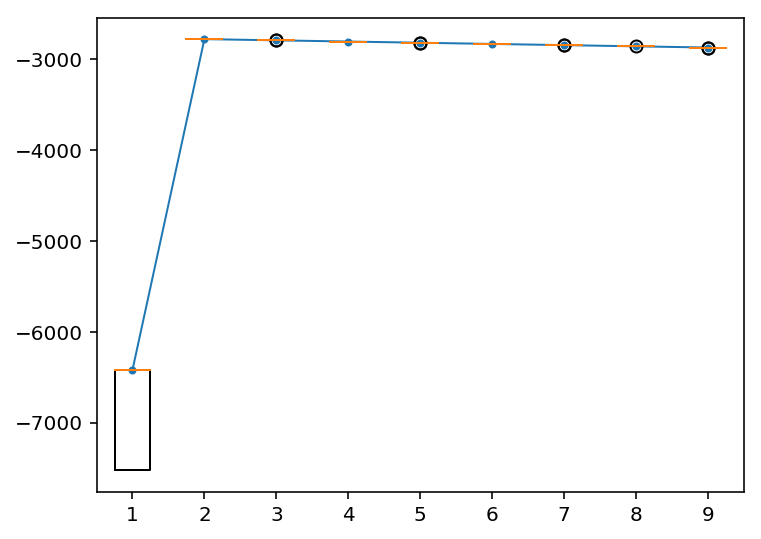

In [9]:
shape = list(map(len, variables.values()))
lowerbounds = np.asarray([Q.compute_lowerbound() for Q in models]).reshape(shape)
plt.plot(variables['num_factors'], lowerbounds.max(axis=1), marker='.')
plt.boxplot(lowerbounds.T, positions=variables['num_factors'])
pass

# Model with community structure

In [8]:
variables, list_params = build_parameters(hyperparameters, seed=list(range(50)))

with multiprocessing.Pool() as pool:
    models = list(tqdm_notebook(pool.imap(ft.partial(fit_model, y), list_params), total=len(list_params)))

HBox(children=(IntProgress(value=0, max=3800), HTML(value='')))

In [9]:
shape = [len(value) for value in variables.values()]
lowerbounds = np.reshape([Q.compute_lowerbound() for Q in models], shape)
_num_groups = np.reshape([len(set(np.argmax(Q['z'].get_moments()[0], axis=1))) for Q in models], shape)

In [10]:
k = np.argmax(lowerbounds, axis=-1)
i, j = np.indices(k.shape)
best_lowerbounds = lowerbounds[i, j, k]
best_num_groups = _num_groups[i, j, k]

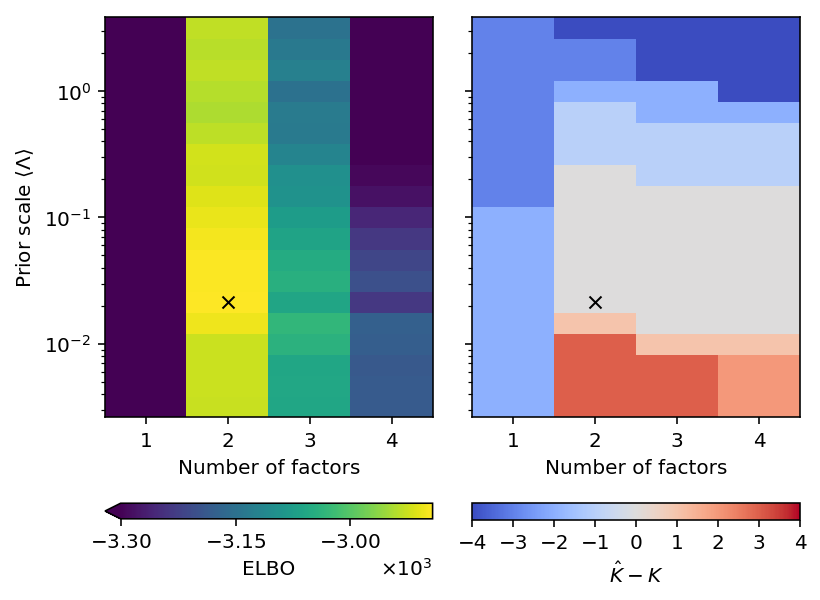

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, True, True)

_x = pcolorcoords(variables['num_factors'])
_y = pcolorcoords(variables['Lambda/scale'], 'log')

mappable = ax1.pcolormesh(_x, _y, best_lowerbounds, vmin=-3.3e3)
# _x, _y = list_args[np.argmax(max_lowerbounds)]
# plt.scatter(_x, _y)
ax1.set_yscale('log')
cb = plt.colorbar(mappable, ax=ax1, orientation='horizontal', extend='min', 
                  ticks=mticker.MaxNLocator(4))
cb.set_label('ELBO')
cb.formatter.set_powerlimits((0, 0))
cb.formatter._useMathText = True
cb.update_ticks()
ax1.set_ylabel(r'Prior scale $\left\langle \Lambda\right\rangle$')

delta = best_num_groups - num_groups
vmax = np.max(np.abs(delta))
mappable = ax2.pcolormesh(_x, _y, delta, cmap='coolwarm', vmax=vmax, vmin=-vmax)
# _x, _y = list_args[np.argmax(max_lowerbounds)]
# plt.scatter(_x, _y)
ax2.set_yscale('log')
cb = plt.colorbar(mappable, ax=ax2, orientation='horizontal')
cb.set_label(r'$\hat K - K$')

for ax in [ax1, ax2]:
    ax.set_xlabel('Number of factors')
    i, j = np.unravel_index(np.argmax(best_lowerbounds), best_lowerbounds.shape)
    ax.scatter(variables['num_factors'][j], variables['Lambda/scale'][i], marker='x', color='k')

fig.tight_layout()

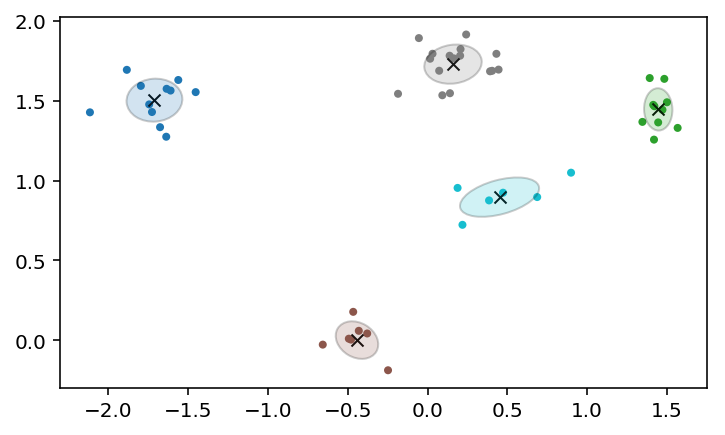

In [12]:
Q = models[np.argmax(lowerbounds)]
_values = Q['A'].get_moments()[0]
fig, ax = plt.subplots()
_labels, lookup = relabel(np.argmax(Q['z'].get_moments()[0], axis=1), True)
_num_groups = len(set(_labels))
pts = ax.scatter(*_values.T, c=_labels, cmap='tab10', vmin=0, vmax=_num_groups - 1)

centroids = Q['mu'].get_moments()[0]
precisions = Q['Lambda'].get_moments()[0]
ax.set_aspect(1)

for i, (centroid, precision) in enumerate(zip(centroids, precisions)):
    j = lookup.get(i)
    if j is not None:
        ax.scatter(*centroid, color='k', marker='x')
        color = cm.tab10(j / (_num_groups - 1))
        ax.add_artist(ellipse_from_precision(centroid, precision, alpha=.2, edgecolor='k', facecolor=color))

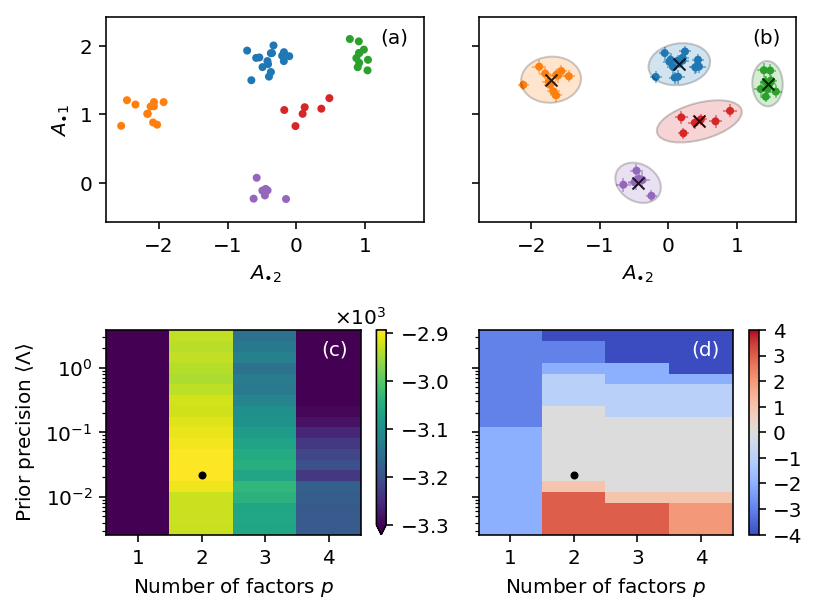

In [15]:
cmap = mcolors.ListedColormap(['C%d' % i for i in range(5)])
fig, axes = plt.subplots(2, 2, sharex='row', sharey='row')

ax1, ax2 = axes[0]

# Perform a reflection to make the data fit better into the plots (this does not change the results)
parity = (-1, 1)
ax1.scatter(*(A * parity).T, c=idx, cmap=cmap)
ax1.set_aspect(1)
permutation = np.asarray([1, 2, 4, 0, 3])
plot_mixture(Q, ax2, permutation=permutation, scale=5, cmap=cmap)

labels, lookup = relabel(evaluate_labels(Q), True)

_A, _A2 = Q['A'].get_moments()
std = _A2 - _A[:, :, None] * _A[:, None]
std = np.sqrt(std[..., np.arange(2), np.arange(2)])

for label in set(labels):
    a = _A[labels == label]
    sx, sy = 3 * std[labels == label].T
    color = cmap(permutation[label] / 4)
    ax2.errorbar(*a.T, sy, sx, ls='none', color=color, zorder=0, alpha=.5)

for ax in (ax1, ax2):
    ax.set_xlabel(r'$A_{\bullet 2}$')
ax1.set_ylabel(r'$A_{\bullet 1}$')
label_axes((ax1, ax2), x=0.95, ha='right')

ax1, ax2 = axes[1]
_x = pcolorcoords(variables['num_factors'])
_y = pcolorcoords(variables['Lambda/scale'], 'log')

mappable = ax1.pcolormesh(_x, _y, best_lowerbounds, vmin=-3.3e3)
# _x, _y = list_args[np.argmax(max_lowerbounds)]
# plt.scatter(_x, _y)
ax1.set_yscale('log')
cb = plt.colorbar(mappable, ax=ax1, extend='min')
# cb.set_label('ELBO')
cb.formatter.set_powerlimits((0, 0))
cb.formatter._useMathText = True
cb.locator = mticker.MaxNLocator(5)
cb.update_ticks()
ax1.set_ylabel(r'Prior precision $\left\langle \Lambda\right\rangle$')

delta = best_num_groups - num_groups
vmax = np.max(np.abs(delta))
mappable = ax2.pcolormesh(_x, _y, delta, cmap='coolwarm', vmax=vmax, vmin=-vmax)
# _x, _y = list_args[np.argmax(max_lowerbounds)]
# plt.scatter(_x, _y)
ax2.set_yscale('log')
cb = plt.colorbar(mappable, ax=ax2)
# cb.set_label(r'$\hat K - K$')

for ax in [ax1, ax2]:
    ax.set_xlabel('Number of factors $p$')
    i, j = np.unravel_index(np.argmax(best_lowerbounds), best_lowerbounds.shape)
    ax.scatter(variables['num_factors'][j], variables['Lambda/scale'][i], marker='.', color='k')

label_axes((ax1, ax2), x=0.95, ha='right', offset=2, color='w')
    
fig.tight_layout()
fig.savefig('../figures/synthetic-sweep.png')
fig.savefig('../figures/synthetic-sweep.pdf')